# Homework 3 of ys3031, EECS 6894

# Problem 1

# Problem 2

In [ ]:
import keras 
model = keras.applications.resnet50.ResNet50(include_top=True,
                                            weights='imagenet',
                                            input_tensor=None,
                                            input_shape=None,
                                            pooling=None,
                                            classes=1000)

In [ ]:
model.summary()

In [ ]:
conv1=9472+256
conv2a=4160+256+36928+256+16640+16640+1024+1024
conv2b=16448+256+36928+256+16640+1024 
conv2c= 16448+256+36928+256+16640+1024
conv3a= 32896+512+147584+512+66048+131584+2048+2048
conv3b= 65664+512+147584+512+66048+2048
conv3c= 65664+512+147584+512+66048+2048                                                                 
conv3d= 65664+512+147584+512+66048+2048
conv4a= 131328+1024+590080+1024+263168+525312+4096+4096
conv4b= 262400+1024+590080+1024+263168+4096
conv4c= 262400+1024+590080+1024+263168+4096                                                                 
conv4d= 262400+1024+590080+1024+263168+4096
conv4e= 262400+1024+590080+1024+263168+4096
conv4f= 262400+1024+590080+1024+263168+4096
conv5a= 524800+2048+2359808+2048+1050624+2099200+8192+8192                                                                 
conv5b= 1049088+2048+2359808+2048+1050624+8192                                                                 
conv5c= 1049088+2048+2359808+2048+1050624+8192                                                                 
convfc= 2049000

conv2 = conv2a+conv2b+conv2c
conv3 = conv3a+conv3b+conv3c+conv3c
conv4 = conv4a+conv4b+conv4c+conv4d+conv4e+conv4f
conv5 = conv5a+conv5b+conv5c

print("conv1:", conv1)
print("conv2:", conv2)
print("conv3:", conv3)
print("conv4:", conv4)
print("conv5:", conv5)

print(conv1+conv2a+conv2b+conv2c+conv3a+conv3b+conv3c+conv3d+conv4a+conv4b+conv4c+conv4d+conv4e+conv4f+conv5a+conv5b+conv5c+convfc)

# Problem 3

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg16 import VGG16
import os

def data_aug(category, starname):
    for filename in os.listdir(os.path.join("data_origin", category, starname)):
        if filename.endswith(".jpg"):
            filenameandpath = os.path.join("data_origin", category, starname, filename)
            print(filenameandpath)
            img = load_img(os.path.join("data_origin", category, starname, filename))
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            i = 0
            datagen = ImageDataGenerator(
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')
            for _ in datagen.flow(img_array, 
                                  batch_size=1, 
                                  save_to_dir=os.path.join("data_expanded", category, starname), 
                                  save_prefix=starname, 
                                  save_format="jpeg"):
                i += 1
                if i > 50:
                    break
                    
data_aug("train", "jennifer")
data_aug("validation", "jennifer")
data_aug("train", "justin")
data_aug("validation", "justin")

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras import regularizers

img_width, img_height = 224, 224

train_data_dir = 'data_expanded/train'
validation_data_dir = 'data_expanded/validation'
epochs = 3
batch_size = 50

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


model_vgg = VGG16(input_shape=input_shape, include_top=False)

model = Sequential()

model.add(model_vgg)
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(256))
top_model.add(Activation('relu'))
top_model.add(Dropout(0.8))
top_model.add(Dense(1))
top_model.add(Activation('sigmoid'))

model.add(top_model)

model.layers[0].trainable = False 

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

top_model.save_weights("./top_model_pre_weights.h5")

Found 993 images belonging to 2 classes.
Found 1190 images belonging to 2 classes.
Epoch 1/3
40/40 [==============================] - 674s 17s/step - loss: 1.3050 - acc: 0.7390 - val_loss: 0.4963 - val_acc: 0.8000
Epoch 2/3
40/40 [==============================] - 655s 16s/step - loss: 0.3121 - acc: 0.8853 - val_loss: 0.2042 - val_acc: 0.9300
Epoch 3/3
40/40 [==============================] - 655s 16s/step - loss: 0.2052 - acc: 0.9317 - val_loss: 0.1568 - val_acc: 0.9425


In [27]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img

def predict_jennifer_or_justin(img_path):
    img_selfie = load_img(img_path, target_size=(224, 224))
    selfie_array = img_to_array(img_selfie)
    selfie_array = selfie_array.reshape((1,) + selfie_array.shape)
    selfie_array /= 255.0
    result = model.predict_classes(selfie_array)
    print(result)

In [13]:
predict_jennifer_or_justin('./selfie/sunyiming.jpeg')
predict_jennifer_or_justin('./selfie/justin.jpeg')
predict_jennifer_or_justin('./selfie/jennifer.jpeg')

[[1]]
[[1]]
[[0]]


# Problem 4

In [14]:
je_pic = load_img('./selfie/jennifer.jpeg', target_size=(224, 224))
je_array = img_to_array(je_pic)
print(je_array.shape)

(224, 224, 3)


In [16]:
import foolbox
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50

# instantiate model
keras.backend.set_learning_phase(0)
# kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(model, bounds=(0, 255), preprocessing=preprocessing)

# get source image and label
image, label = foolbox.utils.imagenet_example()
print(image.shape, type(image))
print(je_array.shape, type(image))

# apply attack on source image
# ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(je_array[:, :, ::-1], label)

(224, 224, 3) <class 'numpy.ndarray'>
(224, 224, 3) <class 'numpy.ndarray'>


/anaconda3/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


In [19]:
print(type(adversarial), adversarial.shape, je_array.shape)

<class 'numpy.ndarray'> (224, 224, 3) (224, 224, 3)


In [26]:
je_array_reshaped = je_array.reshape((1,) + je_array.shape)
adversarial_reshaped = adversarial.reshape((1,) + adversarial.shape)
print(model.predict_classes(je_array_reshaped))
print(model.predict_classes(adversarial_reshaped))

[[0]]
[[1]]


In [28]:
je_img = array_to_img(je_array)
adversarial_img = array_to_img(adversarial)

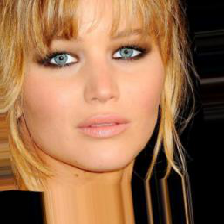

In [29]:
je_img

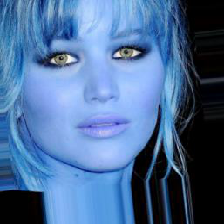

In [30]:
adversarial_img